## Demo inference on MRI T1 image

Data source: MRI data of 3-12 year old children and adults during viewing of a short animated film
https://openneuro.org/datasets/ds000228/versions/1.1.0

In [6]:
from __future__ import generators

import logging
import glob, os, functools
import sys
sys.path.append('../')

import SimpleITK as sitk
from scipy.signal import medfilt
import numpy as np
from numpy import median
import scipy
import nibabel as nib
import skimage
import matplotlib.pyplot as plt
import scipy.misc
from scipy import ndimage
from skimage.transform import resize,rescale
import cv2
import itk
import subprocess
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.zscore import ZScoreNormalize

import pandas as pd
import tensorflow as tf
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 

  
from scripts.densenet_regression import DenseNet
from scripts.unet import get_unet_2D
from scripts.preprocess_utils import load_nii,save_nii, find_file_in_path, iou, enhance_noN4,crop_center, get_id_and_path
from scripts.feret import Calculater
from settings import  target_size_dense_net, target_size_unet, unet_classes, softmax_threshold, scaling_factor
from scripts.infer_selection import get_slice_number_from_prediction, funcy
from scripts.preprocess_utils import closest_value,find_centile,find_exact_percentile_return_number,add_median_labels

import warnings

warnings.filterwarnings('ignore')

physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) == 0:
    physical_devices = tf.config.experimental.list_physical_devices('CPU')
else:   
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
        

In [7]:
import traceback
import subprocess

In [8]:
def select_template_based_on_age(age,neonatal):
    if neonatal:
        if age == 36:
            golden_file_path = "../shared_data/mni_templates/mean/ga_36/template_t1.nii.gz"
        elif age == 37:
            golden_file_path = "../shared_data/mni_templates/mean/ga_37/template_t1.nii.gz"
        elif age == 38:
            golden_file_path = "../shared_data/mni_templates/mean/ga_38/template_t1.nii.gz"
        elif age == 39:
            golden_file_path = "../shared_data/mni_templates/mean/ga_39/template_t1.nii.gz"
        elif age == 40:
            golden_file_path = "../shared_data/mni_templates/mean/ga_40/template_t1.nii.gz"
        elif age == 41:
            golden_file_path = "../shared_data/mni_templates/mean/ga_41/template_t1.nii.gz"
        elif age == 42:
            golden_file_path = "../shared_data/mni_templates/mean/ga_42/template_t1.nii.gz"
        elif age == 43:
            golden_file_path = "../shared_data/mni_templates/mean/ga_43/template_t1.nii.gz"
        elif age == 44:
            golden_file_path = "../shared_data/mni_templates/mean/ga_44/template_t1.nii.gz"
        return golden_file_path
    else:
        age_ranges = {
            "../shared_data/mni_templates/nihpd_asym_04.5-08.5_t1w.nii" : {"min_age":3, "max_age":7},
                "../shared_data/mni_templates/nihpd_asym_07.5-13.5_t1w.nii": {"min_age":8, "max_age":13},
                "../shared_data/mni_templates/nihpd_asym_13.0-18.5_t1w.nii": {"min_age":14, "max_age":35}}
        for golden_file_path, age_values in age_ranges.items():
            if age_values['min_age'] <= int(age) and int(age) <= age_values['max_age']: 
                print(golden_file_path)
                return golden_file_path

# compute the cropline
def compute_crop_line(img_input,infer_seg_array_2d_1,infer_seg_array_2d_2):
    binary = img_input>-1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    img = cv2.drawContours(mask, contours, -1, (255),1)

    max_y,ind_max = 0,0
    min_y,ind_min = 512,0
    if len(contours)>0:
        for i in range(0,len(contours[0])):
            x,y = contours[0][i][0]
            if y<=min_y:
                min_y,ind_min = y,i
            if y>=max_y:
                max_y,ind_max = y,i
        crop_line = (contours[0][ind_min][0][0]+contours[0][ind_max][0][0])/2
        
        return crop_line
    else:
        return 100
    
# register the MRI to the template     
def register_to_template_cmd(input_image_path, output_path, fixed_image_path,rename_id,create_subfolder=True):
    if "nii" in input_image_path and "._" not in input_image_path:
        try:
            """
            return_code = subprocess.call("elastix -f "+fixed_image_path+" -m "+input_image_path+" -out "+\
            output_path + " -p ../shared_data/mni_templates/Parameters_Rigid.txt", shell=True,\
            stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
            """
            return_code = subprocess.call("/Users/philipmattisson/Desktop/Centile/software/elastix-5.1.0-mac/bin/elastix -f " +
                                           fixed_image_path + " -m " + input_image_path + " -out " 
                                           + output_path + " -p /Users/philipmattisson/Desktop/Centile/software/git/itmt/shared_data/mni_templates/Parameters_Rigid.txt", 
                                           shell=True, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
            print(return_code)

            if return_code == 0:
                print("Registered ", rename_id)
                result_image = itk.imread(output_path+'/result.0.mhd',itk.F)
                itk.imwrite(result_image, output_path+"/"+rename_id+".nii.gz")
            else:
                print("Error registering ", rename_id)
                return_code = 1
        except Exception as e:
            print("is elastix installed?")
            print("An error occurred:", e)
            traceback.print_exc()
            return_code = 1
           
        
def filter_islands(muscle_seg):
    img = muscle_seg.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(img.shape, np.uint8)
    cnt_mask = np.zeros(img.shape, np.uint8)
    area = 0
    c=0
    if len(contours) != 0:
        c = max(contours, key = cv2.contourArea)
        area = cv2.contourArea(c)
        mask = cv2.fillPoly(mask, pts=[c], color=(255, 0, 0))
        cnt_mask =  cv2.drawContours(cnt_mask, [c], -1, (255, 255, 255), 0)#cv.drawContours(cnt_mask, [c], 0, (255,255,0), 2)
    return mask, area, c

In [9]:
# change paths to your data here
#img_path = '../shared_data/sub-pixar066_anat_sub-pixar066_T1w.nii.gz' # input raw t1 MRI path
#img_path = '/Users/philipmattisson/Desktop/Centile/data/TRUE_BRAIN/STD_HEAD_NECK_U-EXT_Head_82252_80448.nii'
#img_path = '/Users/philipmattisson/Desktop/Centile/data/T1_UKB5563485.nii.gz'"
#img_path = '/Users/philipmattisson/Desktop/Centile/data/sub-CC00219XX13_ses-86600_T1w.nii.gz'
img_path = '/Users/philipmattisson/Desktop/Centile/data/outlierDHCP.nii.gz'
age = 44 # age of subject
gender = "F" # gender
model_weight_path_segmentation = '../model/unet_models/test/itmt1.hdf5'
model_weight_path_selection = '../model/densenet_models/test/itmt1.hdf5'
path_to = "../output/" # save to

# MNI templates http://nist.mni.mcgill.ca/pediatric-atlases-4-5-18-5y/
age_ranges = {"../shared_data/mni_templates/nihpd_asym_04.5-08.5_t1w.nii" : {"min_age":3, "max_age":7},
                "../shared_data/mni_templates/nihpd_asym_07.5-13.5_t1w.nii": {"min_age":8, "max_age":13},
                "../shared_data/mni_templates/nihpd_asym_13.0-18.5_t1w.nii": {"min_age":14, "max_age":35},
                "/Users/philipmattisson/Downloads/MRI2circ-main/shared_data/mni_templates/mean/ga_43/template_t1.nii.gz": {"min_age":36, "max_age":100}
                }


threshold = 0.75 # ie must be present on 3 out of 4 predictions

In [10]:
import os
# Set the library path for the current script
os.environ['DYLD_LIBRARY_PATH'] = '/Users/philipmattisson/Desktop/Centile/software/elastix-5.1.0-mac/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

### Preprocessing: register, rescale, normalize

In [11]:
import ants

In [12]:
def register_images(fixed_image_path, moving_image_path, output_path):
    # Load the fixed and moving images
    fixed_image = ants.image_read(fixed_image_path)
    moving_image = ants.image_read(moving_image_path)

    # Perform rigid registration
    registration = ants.registration(
        fixed=fixed_image,
        moving=moving_image,
        type_of_transform='Rigid'
    )

    # Get the transformed moving image
    transformed_image = registration['warpedmovout']

    # Save the transformed image
    ants.image_write(transformed_image, output_path)

    return registration, transformed_image

('R', 'A', 'S')
../output/outlierDHCP
Registering to template: ../shared_data/mni_templates/mean/ga_44/template_t1.nii.gz
../output/outlierDHCP
stdout: 
elastix is started at Wed Jul 31 13:27:54 2024.

which elastix:   /Users/philipmattisson/Desktop/Centile/software/elastix-5.1.0-mac/bin/elastix
  elastix version: 5.1.0
  Git revision SHA: d652938573e5f193955908eba225a854b31ce36a
  Git revision date: Thu Jan 12 14:20:18 2023 +0100
  Build date: Jan 12 2023 13:49:04
  Compiler: Clang version Apple LLVM 13.0.0 (clang-1300.0.29.30)
  Compiler: GCC version Apple LLVM 13.0.0 (clang-1300.0.29.30)
  Memory address size: 64-bit
  CMake version: 3.18.3
  ITK version: 5.3.0

Command-line arguments: 
  -f ../shared_data/mni_templates/mean/ga_44/template_t1.nii.gz -m /Users/philipmattisson/Desktop/Centile/data/outlierDHCP.nii.gz -out ../output/outlierDHCP -p /Users/philipmattisson/Desktop/Centile/software/git/itmt/shared_data/mni_templates/Parameters_Rigid.txt

elastix runs at: MacBook-Pro.local
 

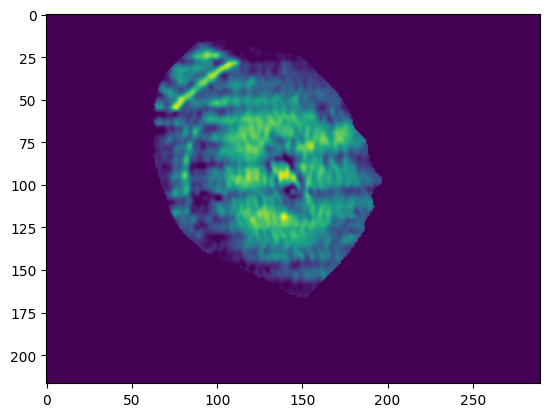

In [13]:
# load image
from hmac import new


image, affine = load_nii(img_path)
plt.imshow(image[:,:,1])
print(nib.aff2axcodes(affine))

# path to store registered image in
new_path_to = path_to+img_path.split("/")[-1].split(".")[0]
if not os.path.exists(new_path_to):
    os.mkdir(new_path_to)

print(new_path_to)
#new_path_to = "/Users/philipmattisson/Desktop/Centile/software/git/itmt/output/test_output"
# register image to MNI template
golden_file_path = select_template_based_on_age(age,neonatal=True)
#golden_file_path = "/Users/philipmattisson/Desktop/Centile/software/git/itmt/shared_data/mni_templates/nihpd_asym_04.5-08.5_t1w.nii"
print("Registering to template:", golden_file_path)

try:
    print(new_path_to)
    result = subprocess.run(["/Users/philipmattisson/Desktop/Centile/software/elastix-5.1.0-mac/bin/elastix", "-f", golden_file_path, "-m", img_path , "-out", new_path_to , "-p", "/Users/philipmattisson/Desktop/Centile/software/git/itmt/shared_data/mni_templates/Parameters_Rigid.txt"], capture_output=True, text=True)
    print("stdout:", result.stdout)
    print("stderr:", result.stderr)
    if result.returncode == 0:
        print("Registered ")
        result_image = itk.imread(new_path_to+'/result.0.mhd',itk.F)
        itk.imwrite(result_image, new_path_to+"/"+"registered"+".nii.gz")
    else:
        print("Error registering ", "with return code", result.returncode)
except Exception as e:
    print("An error occurred:", e)

#register_to_template_cmd(img_path, new_path_to, golden_file_path,"registered.nii.gz", create_subfolder=False)

# Ants registration

('R', 'A', 'S')
../output/outlierDHCP
Registering to template: ../shared_data/mni_templates/mean/ga_44/template_t1.nii.gz


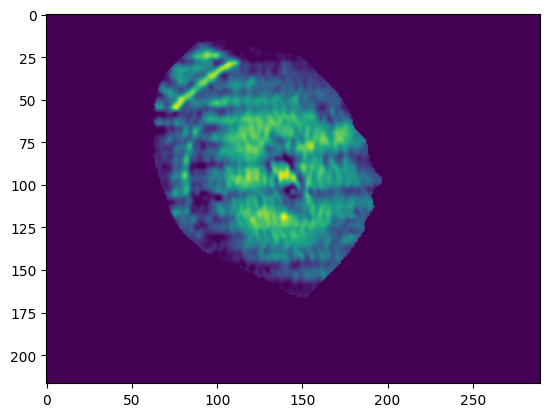

In [14]:
from hmac import new


image, affine = load_nii(img_path)
plt.imshow(image[:,:,1])
print(nib.aff2axcodes(affine))

# path to store registered image in
new_path_to = path_to+img_path.split("/")[-1].split(".")[0]
if not os.path.exists(new_path_to):
    os.mkdir(new_path_to)

print(new_path_to)
#new_path_to = "/Users/philipmattisson/Desktop/Centile/software/git/itmt/output/test_output"
# register image to MNI template
golden_file_path = select_template_based_on_age(age,neonatal=True)
#golden_file_path = "/Users/philipmattisson/Desktop/Centile/software/git/itmt/shared_data/mni_templates/nihpd_asym_04.5-08.5_t1w.nii"
print("Registering to template:", golden_file_path)
registration, transformed_image = register_images(golden_file_path, img_path, new_path_to+"/registered.nii.gz")

('R', 'A', 'S')


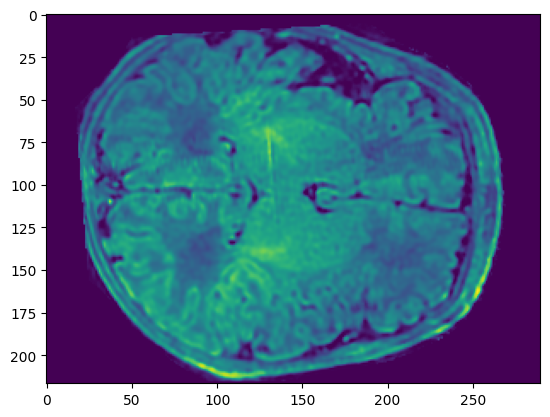

In [15]:
plt.imshow(image[:,:,146])
print(nib.aff2axcodes(affine))

In [16]:
# enchance and zscore normalize image
if not os.path.exists(new_path_to+"/no_z"):
    os.mkdir(new_path_to+"/no_z")
print(new_path_to)
image_sitk =  sitk.ReadImage(new_path_to+"/registered.nii.gz")
#image_sitk = sitk.ReadImage("/Users/philipmattisson/Desktop/Centile/software/git/itmt/output/sub-pixar066_anat_sub-pixar066_T1w/registered.nii.gz")
image_array  = sitk.GetArrayFromImage(image_sitk)
image_array = enhance_noN4(image_array)
image3 = sitk.GetImageFromArray(image_array)

sitk.WriteImage(image3,new_path_to+"/no_z/registered_no_z.nii") 
cmd_line = "zscore-normalize "+new_path_to+"/no_z/registered_no_z.nii -o "+new_path_to+'/registered_z.nii'
subprocess.getoutput(cmd_line)     
print(cmd_line)
print("Preprocessing done!")

../output/outlierDHCP
zscore-normalize ../output/outlierDHCP/no_z/registered_no_z.nii -o ../output/outlierDHCP/registered_z.nii
Preprocessing done!


### Load models

In [17]:
# load models
model_selection = DenseNet(img_dim=(256, 256, 1), 
                nb_layers_per_block=12, nb_dense_block=4, growth_rate=12, nb_initial_filters=16, 
                compression_rate=0.5, sigmoid_output_activation=True, 
                activation_type='relu', initializer='glorot_uniform', output_dimension=1, batch_norm=True )
model_selection.load_weights(model_weight_path_selection)
print('\n','\n','\n','loaded:' ,model_weight_path_selection)  


 
 
 loaded: ../model/densenet_models/test/itmt1.hdf5


### Inference - slice detection

In [18]:
image_sitk = sitk.ReadImage(new_path_to+'/registered_z.nii')    
windowed_images  = sitk.GetArrayFromImage(image_sitk)           

In [19]:
def run_neuroruler_cli(image_path, slice_label, x_rotation=0, y_rotation=0, z_rotation=0):
    command = f"python /Users/philipmattisson/offline/OfflineCentile/mri2circV2/NeuroRuler-main/cli.py --slice={slice_label} --x={x_rotation} --y={y_rotation} --z={z_rotation} {image_path}"

    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    if result.returncode == 0:
        # Extract the circumference value from the output
        output = result.stdout.strip()
        circumference = float(output.split(":")[1].split()[0])
        return circumference
    else:
        print("Error running NeuroRuler CLI:")
        print(result.stderr)
        return None

In [20]:
resize_func = functools.partial(resize, output_shape=model_selection.input_shape[1:3],
                                            preserve_range=True, anti_aliasing=True, mode='constant')
series = np.dstack([resize_func(im) for im in windowed_images])
series = np.transpose(series[:, :, :, np.newaxis], [2, 0, 1, 3])
series_n = []

for slice_idx in range(2, np.shape(series)[0]-2):
    im_array = np.zeros((256, 256, 1, 5))
    
    # create MIP of 5 slices = 5mm 
    im_array[:,:,:,0] = series[slice_idx-2,:,:,:].astype(np.float32)
    im_array[:,:,:,1] = series[slice_idx-1,:,:,:].astype(np.float32)
    im_array[:,:,:,2] = series[slice_idx,:,:,:].astype(np.float32)
    im_array[:,:,:,3] = series[slice_idx+1,:,:,:].astype(np.float32)
    im_array[:,:,:,4] = series[slice_idx+2,:,:,:].astype(np.float32)
            
    im_array= np.max(im_array, axis=3)
            
    series_n.append(im_array)
    series_w = np.dstack([funcy(im) for im in series_n])
    series_w = np.transpose(series_w[:, :, :, np.newaxis], [2, 0, 1, 3])
        
predictions = model_selection.predict(series_w)
slice_label = get_slice_number_from_prediction(predictions)
print("Predicted slice:", slice_label)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step
Predicted slice: 148


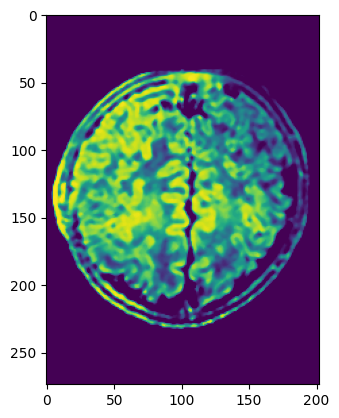

In [21]:
plt.imshow(image_array[slice_label,:,:])

### Inference - segmentation

In [22]:
img = nib.load(new_path_to+'/registered_z.nii')  
image_array, affine = img.get_fdata(), img.affine
infer_seg_array_3d_1,infer_seg_array_3d_2 = np.zeros(image_array.shape),np.zeros(image_array.shape)
print(np.asarray(nib.aff2axcodes(affine)))

['L' 'P' 'S']


# Philip lines for contour

In [23]:
result = run_neuroruler_cli(new_path_to+"/registered.nii.gz", slice_label)

In [24]:
result

324.098

In [31]:
import SimpleITK as sitk
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_and_visualize(image_path, slice_num):
    # Load the image
    image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(image)

    # Extract the 2D slice
    slice_2d = image_array[slice_num]

    # Convert to SimpleITK image
    sitk_slice = sitk.GetImageFromArray(slice_2d)

    # Apply smoothing
    smooth_slice = sitk.CurvatureAnisotropicDiffusion(sitk.Cast(sitk_slice, sitk.sitkFloat64))

    # Apply Otsu thresholding
    otsu_filter = sitk.OtsuThresholdImageFilter()
    thresholded = otsu_filter.Execute(smooth_slice)

    # Hole filling
    hole_filling = sitk.BinaryGrindPeakImageFilter().Execute(thresholded)

    # Invert the image
    inverted = sitk.NotImageFilter().Execute(hole_filling)

    # Select largest component
    component_image = sitk.ConnectedComponent(inverted)
    sorted_component_image = sitk.RelabelComponent(component_image, sortByObjectSize=True)
    largest_component = sorted_component_image == 1

    # Get contour
    contour_image = sitk.BinaryContourImageFilter().Execute(largest_component)

    # Convert back to numpy array
    contour_array = sitk.GetArrayFromImage(contour_image)

    # Find contours using OpenCV
    contours, _ = cv2.findContours(contour_array.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate circumference
    if len(contours) > 0:
        circumference = cv2.arcLength(contours[0], True)
    else:
        circumference = 0

    # Visualize
    plt.figure(figsize=(10, 10))
    plt.imshow(slice_2d, cmap='gray')
    if len(contours) > 0:
        # Swap x and y coordinates and subtract from image height to correct alignment
        contour_plot = np.array(contours[0][:, 0, :])
        contour_plot[:, [0, 1]] = contour_plot[:, [1, 0]]
        plt.plot(contour_plot[:, 1], contour_plot[:, 0], 'r-', linewidth=2)
    plt.title(f"Head Circumference: {circumference:.2f} pixels")
    plt.axis('off')
    plt.show()

    return circumference, contours[0] if len(contours) > 0 else None

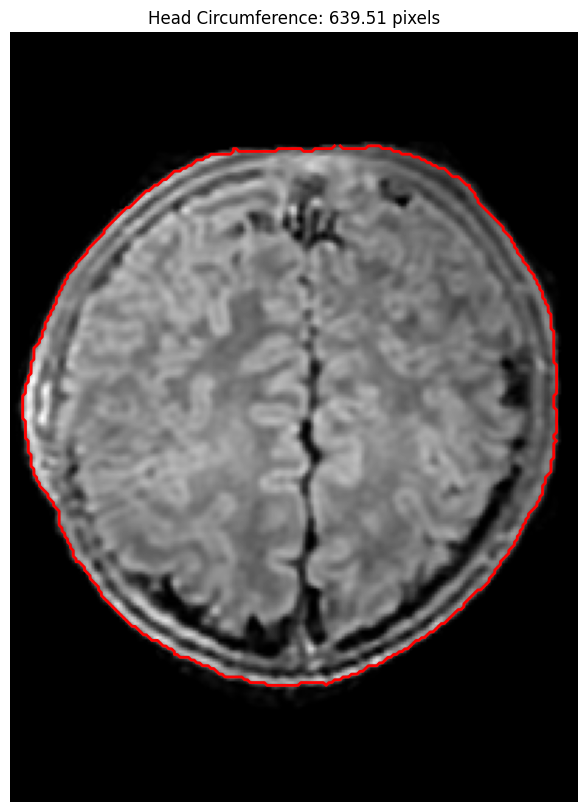

In [32]:
result = process_and_visualize(new_path_to+"/registered.nii.gz", slice_label)

In [28]:
import math

In [29]:
def euclidean(x, y):
    return math.sqrt((y[0] - x[0])**2 + (y[1] - x[1])**2)

def get_contour(img_input):
    cnt, perimeter, max_cnt = 0, 0, 0
    binary = img_input > -1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv2.contourArea(contour) > cnt:
            cnt = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            max_cnt = contour  
            convexHull = cv2.convexHull(contour)
    
    p = 0
    for i in range(1, len(convexHull)):
        p += euclidean(convexHull[i][0], convexHull[i - 1][0])
    
    return round(perimeter, 2), round(p, 2)

In [30]:
img_color = cv2.cvtColor(image_array_2d , cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_color, [max_cnt], 0, (0,255,0), 2)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'image_array_2d' is not defined

In [ ]:
image_array_2d = image_array[:, 15:-21, slice_label] 
perimeter_opencv, perimeter_convex = get_contour(image_array_2d)

In [ ]:
print(f'perimeter_opencv {perimeter_opencv/2}, perimeter_convex {perimeter_convex/2}')


perimeter_opencv 199.065, perimeter_convex 181.32


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy.signal

def get_contours_for_visualization(img_input):
    binary = img_input > -1.7
    binary_smoothed = scipy.signal.medfilt(binary.astype(int), 51)
    img = binary_smoothed.astype('uint8')
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour
    max_cnt = max(contours, key=cv2.contourArea)
    convex_hull = cv2.convexHull(max_cnt)
    
    return max_cnt, convex_hull

def visualize_contours(image_array_2d):
    # Get contours and convex hull
    largest_contour, convex_hull = get_contours_for_visualization(image_array_2d)
    
    # Create a copy of the image for drawing
    img_display = cv2.normalize(image_array_2d, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_GRAY2RGB)

    # Draw the contours
    cv2.drawContours(img_display, [largest_contour], -1, (0, 255, 0), 2)

    # Draw the convex hull
    cv2.drawContours(img_display, [convex_hull], -1, (0, 0, 255), 2)

    # Display the image with contours
    plt.figure(figsize=(10, 10))
    plt.imshow(img_display)
    plt.title('Image with Largest Contour and Convex Hull')
    plt.axis('off')
    plt.show()

# Usage:
# image_array_2d = image_array[:, 15:-21, slice_label] 
# visualize_contours(image_array_2d)

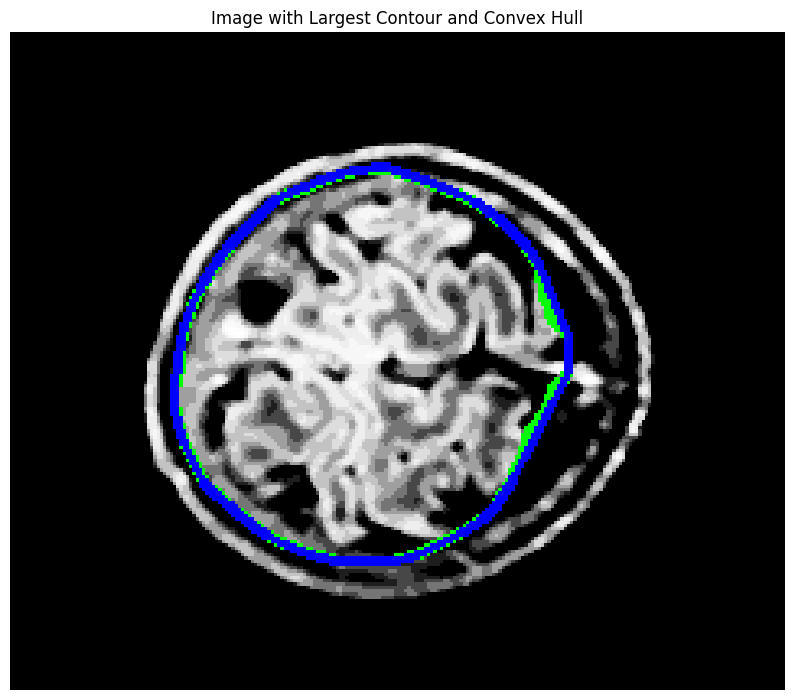

In [ ]:
image_array_2d = image_array[:, 15:-21, slice_label] 
visualize_contours(image_array_2d)